In [131]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [132]:
## DATA PREP PART ##

# 2. We are only going to use the feature columns
# “DEATH_EVENT, time, age, high_blood_pressure, ejection_fraction, serum_creatinine, 
# serum_sodium”.
# Extract them from the original dataframe.

df_original = pd.read_csv('checkpoint_heart_failure_clinical_records_dataset.csv')

features_name = ['DEATH_EVENT', 'time', 'age', 'high_blood_pressure', 'ejection_fraction', 'serum_creatinine','serum_sodium']
df_prepped = df_original[features_name]
# label = df_original['DEATH_EVENT']

# y = np.c_[label]
# X = np.c_[features]


In [133]:


# 3. Create a new column called “age_text”, where the value is “low” for age<=56, “high” for age>= 
# 73 and “medium” for ages between.
# remove the age column

def get_age_text(df):
    if df <= 56:
        return "low"
    elif df >=73:
        return "high"
    else:
        return "medium"

# Using the .apply function of the dataframe to apply the logic on numbers
df_prepped["age_text"] = df_prepped["age"].apply(get_age_text)


C:\Users\MariusDyrseth\AppData\Local\Temp\ipykernel_17944\384029396.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prepped["age_text"] = df_prepped["age"].apply(get_age_text)


In [134]:
# 4. Use the “from sklearn.preprocessing import OneHotEncoder” and do a one hot encoding of 
# “age_text” and add the three columns to the dataframe with the names “age_text0, age_text1 
# and age_text2”. It is irrelevant which of the columns “low”, “medium” and “high” is placed in 
# which column. Remove the “age_text” from the dataframe.

age_category_encoder = OneHotEncoder(sparse_output=False)

age_category_encoder.fit(df_prepped[["age_text"]])

train_one_hot_grade = age_category_encoder.transform(df_prepped[["age_text"]])

# Getting the feature names
age_category_names = age_category_encoder.get_feature_names_out()

#setting the feature names to be the transformed values from age_text
df_prepped[age_category_names] = train_one_hot_grade

# dropping age_text from the df
df_prepped = df_prepped.drop("age_text", axis='columns')

C:\Users\MariusDyrseth\AppData\Local\Temp\ipykernel_17944\3806557794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prepped[age_category_names] = train_one_hot_grade
C:\Users\MariusDyrseth\AppData\Local\Temp\ipykernel_17944\3806557794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prepped[age_category_names] = train_one_hot_grade
C:\Users\MariusDyrseth\AppData\Local\Temp\ipykernel_17944\3806557794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

C:\Users\MariusDyrseth\AppData\Local\Temp\ipykernel_17944\3741225640.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_scale.rename(columns = {'ejection_fraction':'ejection_fraction_sc',


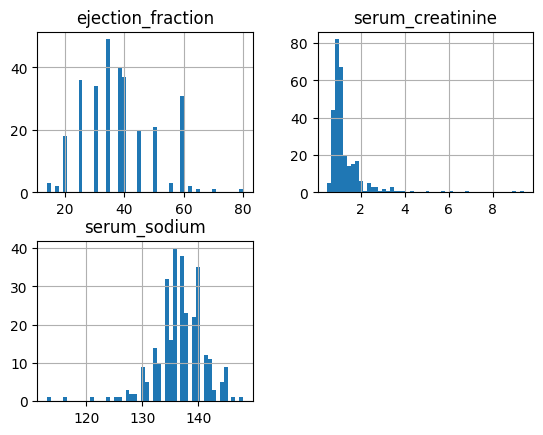

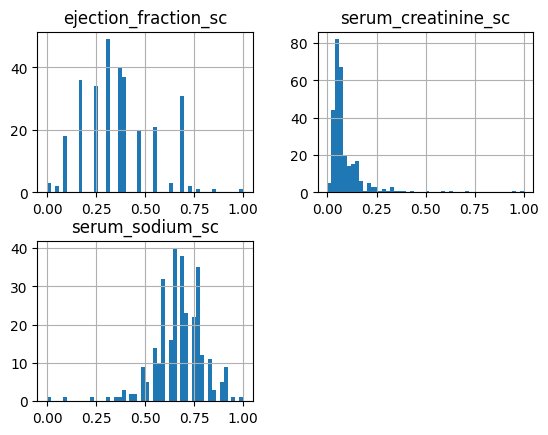

In [135]:
# 5. Use one of “from sklearn.preprocessing import MinMaxScaler” or “from sklearn.preprocessing 
# import StandardScaler” and scale the columns “ejection_fraction, serum_creatinine, 
# serum_sodium”.
# Add the columns back to the dataframe with the column names “ejection_fraction_sc, 
# serum_creatinine_sc, serum_sodium_sc”, and remove the columns “ejection_fraction, 
# serum_creatinine, serum_sodium”.

# Using MinMaxScaler as StandardScaler gave some minus values, and otherwise it looked the same from the hist graphs at first glance
mm_scaler = MinMaxScaler()
mm_labels = ["ejection_fraction", "serum_creatinine", "serum_sodium"]
mm_new_lablels = ["ejection_fraction_sc", "serum_creatinine_sc", "serum_sodium_sc"]
df_to_scale = df_prepped[mm_labels]

df_to_scale.hist(bins=50)
mm_scaler.fit(df_to_scale)

# Perform scale
X_pos = mm_scaler.transform(df_to_scale)

# Rename the colums, add more elegant way of doing this if more time later
df_to_scale.rename(columns = {'ejection_fraction':'ejection_fraction_sc', 
                              "serum_creatinine":"serum_creatinine_sc",
                              "serum_sodium":"serum_sodium_sc"}, inplace = True)

# Put it in a dataframe and display it
df_to_scale_scaled = pd.DataFrame(X_pos, columns=df_to_scale.columns)

df_to_scale_scaled.hist(bins=50)

# Adding df tables to working df
df_prepped[mm_new_lablels] = df_to_scale_scaled

#dropping the tables with the previous labels
df_prepped = df_prepped.drop(mm_labels, axis='columns')

In [136]:
## Classification PART ##
# 1. From the prepped dataset above, extract the column “DEATH_EVENT” as y, and “age_text0, 
# age_text1, age_text2, high_blood_pressure, ejection_fraction_sc, serum_creatinine_sc, 
# serum_sodium_sc” as X.
# use the “np.c_[ ]” to get X and y in numpy format ready for training.

c_label = df_prepped['DEATH_EVENT']

# I renamed my age_text as high low or medium instead of 0 1 2
c_features_names = ["age_text_high",  "age_text_low", "age_text_medium", "high_blood_pressure", "ejection_fraction_sc", "serum_creatinine_sc", "serum_sodium_sc"]
c_features = df_prepped[c_features_names]
y = np.c_[c_label]
X = np.c_[c_features]


In [137]:
# 2. Use the “from sklearn.model_selection import train_test_split” and split X and y into X_train, 
# X_test, y_train and y_test. Using a 20% test data size.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# 1 Worse than naive
# 4 Worse than naive
# 5 Worse than naive
# 420 better than naive


In [138]:
# 3. Train a logistic regression algorithm on the training data.
model_logreg = LogisticRegression()
model_logreg.fit(X_train, np.ravel(y_train,order='C'))# Adding this as it was giving a warning if not using ravel, as it was expceting a 1D array

LogisticRegression()

In [139]:
# 4. Make prediction using the training and test data, name the prediction variables y_train_pred 
# and y_test_pred. 
# Create a y_test_pred_naive which has the same shape as y_test, but only predicts the most 
# common label.

y_train_pred = model_logreg.predict(X_train)
y_test_pred = model_logreg.predict(X_test)

# Make the naive model that only guesses the most common label
# y_test_pred_naive = np.full(y.shape, most_frequent_death_event_value)

y_test_pred_naive = np.full(y_test.shape, np.median(y))

Trained 
Accuracy: 0.7154811715481172
Precsision: 0.6896551724137931
Recall for: 0.25316455696202533
Test 
Accuracy: 0.7666666666666667
Precsision: 0.6666666666666666
Recall for: 0.35294117647058826
Naive 
Accuracy: 0.7166666666666667
Precsision: nan
Recall for: 0.0


C:\Users\MariusDyrseth\AppData\Local\Temp\ipykernel_17944\789482794.py:17: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(fp+tp)


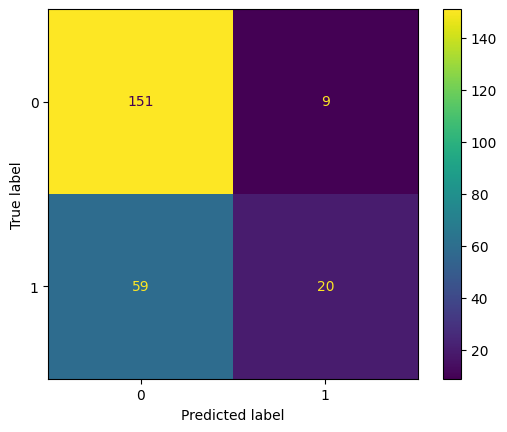

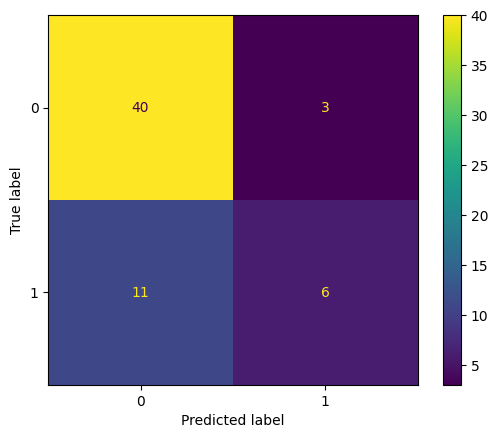

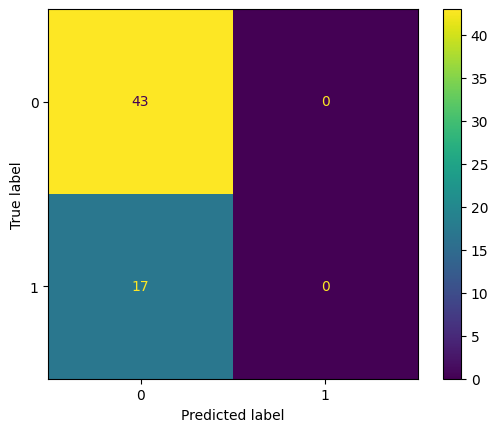

In [140]:
# 5. Use “from sklearn.metrics import accuracy_score” and calculate the train, test, and test_naive 
# accuracy.
# Also using “from sklearn.metrics import confustion_matrix” and print the train, test, and 
# test_naive confusion matrix.
# What are your conclusion, is the model working well compared to the naive predictions?

def perform_tests(train_data, pred_data, test_type_string):
    train = accuracy_score(train_data, pred_data)
    print(test_type_string)

    cm_train = confusion_matrix(train_data, pred_data)
    ConfusionMatrixDisplay(cm_train).plot()
    # tn = cm_train[0,0]
    fp = cm_train[0,1]
    fn = cm_train[1,0]
    tp = cm_train[1,1]
    precision = tp/(fp+tp)
    recall = tp/(tp+fn)

    print(f'Accuracy: {train}')
    print(f'Precsision: {precision}')
    print(f'Recall for: {recall}')
    print("="*10)

perform_tests(y_train, y_train_pred, "Trained ")
perform_tests(y_test, y_test_pred, "Test ")
perform_tests(y_test, y_test_pred_naive, "Naive ")

# It appears the trained model is slightly worse than the test model, but as for the naive model, 
# it performs slightly better than naive, though in some random states, in the majority of random  states, the accuracy is worse on
# trained than it is on naive, but test usually scores higher than the naive model
# It looks like the models are for the most part slightly better or somewhat better than the naive model


In [141]:
# Regression PART #
# 1. From the prepped dataset above extract all columns, but only the rows where “DEATH_EVENT” 
# is True (or 1).

df_only_death = df_prepped.loc[df_prepped["DEATH_EVENT"] == 1]

In [142]:
# 2. From the data with only death instances, extract the column “time” as y, and “age_text0, 
# age_text1, age_text2, high_blood_pressure, ejection_fraction_sc, serum_creatinine_sc, 
# serum_sodium_sc” as X.
# use the “np.c_[ ]” to get X and y in numpy format ready for training.

r_label = df_only_death["time"]
r_features_names = ["age_text_high",  "age_text_low", "age_text_medium", "high_blood_pressure", "ejection_fraction_sc", "serum_creatinine_sc", "serum_sodium_sc"]
r_features = df_only_death[r_features_names]
y = np.c_[r_label]
X = np.c_[r_features]

In [143]:
# 3. Use the “from sklearn.model_selection import train_test_split” and split X and y into X_train_r, 
# X_test_r, y_train_r and y_test_r. Using a 20% test data size.

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y, test_size=0.2, random_state=5)

In [144]:
# 4. Train a linear regression algorithm on the training data.

model_linreg = LinearRegression()
model_linreg.fit(X, y)

LinearRegression()

In [145]:
# 5. Make prediction using the training and test data, name the prediction variables y_train_pred_r 
# and y_test_pred_r. 

# Create a y_test_pred_naive_r which has the same shape as y_test_r, but only predicts the 
# average time for the patients who died.

y_train_pred_r = model_linreg.predict(X_train_r)
y_test_pred_r = model_linreg.predict(X_test_r)

# Make the naive model that only guesses the most common label based on average

y_test_pred_naive_r = np.full(y_test_r.shape, np.average(y))

In [146]:
# 7. Use “from sklearn.metrics import mean_square_error” and “from sklearn.metrics import 
# mean_absolute_error” and calculate the train, test, and test_naive scores. 
# What are your conclusion, is the model working well compared to the naive predictions?

def r_perform_tests(train_data, pred_data, test_type_string):

    print(test_type_string)
    mae = mean_absolute_error(train_data, pred_data)
    mse = mean_squared_error(train_data, pred_data)
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print("="*10)


r_perform_tests(y_train_r, y_train_pred_r, "R_Trained ")
r_perform_tests(y_test_r, y_test_pred_r, "R_Test ")
r_perform_tests(y_test_r, y_test_pred_naive_r, "R_Naive ")

# Depending on the random state it's vastly varied if the predictions are better than the naive model
# Random State 5: Trained model is better, and test is only slightly better than the naive model
# Random State 15: Trained model is better, test is slightly worse
# Random State 17: Trained model is better, test is slightly worse
# Random State 18: Trained model is worse and test model is worse
# With how I see the data, the naive model is often slightly worse, but not by much as the model with various
# random states only sometimes gets over 50% correctness
# This may be due to the sample size and the randomness in picking the values to test on wheter the naive preforms good or not


R_Trained 
MAE: 50.98293240004161
MSE: 3983.0103260065325
R_Test 
MAE: 38.744952890695444
MSE: 1903.2256354984268
R_Naive 
MAE: 37.23125
MSE: 1890.281879340278
